In [2]:
#This code is similar to the code given by sir in one of his slides
#importing the required modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import ndimage
import pandas as pd
from matplotlib.patches import Ellipse
import emcee

In [3]:
#Defining the data
data = pd.read_csv('arxiv.csv')
xdata = data['x'].values
ydata = data['y'].values
sigma_y = data['sigma_y'].values
np.random.seed(42)

In [4]:
#Fit with emcee
def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)


ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,
                                args=[xdata, ydata])
sampler.run_mcmc(starting_guesses, nsteps)
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T


In [5]:
# Visualize the results
# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20, smoothing=3):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    sigma = L_cumsum[i_unsort].reshape(shape)

    if smoothing > 1:
        sigma = ndimage.zoom(sigma, smoothing)
        xbins = np.linspace(xbins[0], xbins[-1], sigma.shape[0] + 1)
        ybins = np.linspace(ybins[0], ybins[-1], sigma.shape[1] + 1)
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, sigma


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False,
                    nbins=20, smoothing=3, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1],
                                              nbins, smoothing)

    ax.contour(xbins, ybins, sigma.T, levels=[0.683 ** 2, 0.955 ** 2], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(Sigma):
    # See Ivezic, Connolly, VanderPlas, and Gray, section 3.5.2
    sigma_x2 = Sigma[0, 0]
    sigma_y2 = Sigma[1, 1]
    sigma_xy = Sigma[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy, sigma_x2 - sigma_y2)
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha

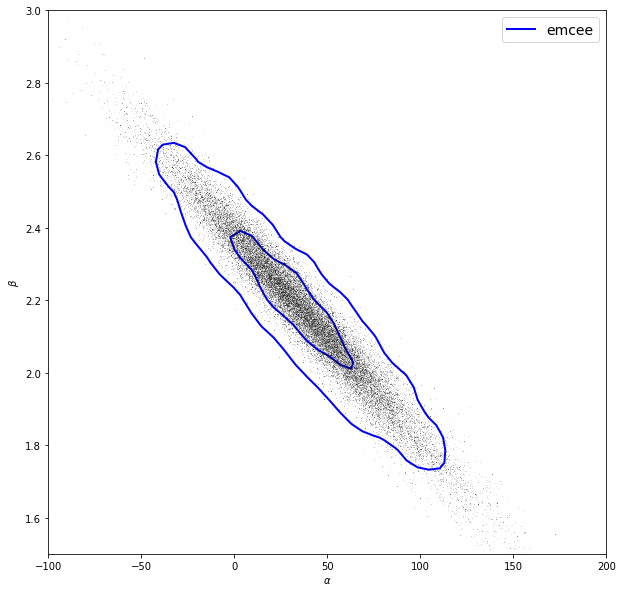

In [9]:
#plot the data
fig, ax = plt.subplots(figsize=(10, 10))

plot_MCMC_trace(ax, xdata, ydata, emcee_trace, True,colors='blue', linewidths=2)

ax.plot([0, 0], [0, 0], '-b', lw=2)

ax.legend(ax.lines[-1:] + ax.collections[::2],
          ['emcee'], fontsize=14)

ax.set_xlim(-100, 200)
ax.set_ylim(1.5,3)

plt.show()
